In [49]:
# !rm -rf dataset
![[ ! -d "dataset" ]] && gdown --id 1D3nQUsn0dKCZwSLsRiWMWur5hui9c6Qe

Downloading...
From: https://drive.google.com/uc?id=1D3nQUsn0dKCZwSLsRiWMWur5hui9c6Qe
To: /content/dataset.zip
13.0MB [00:00, 79.4MB/s]


In [50]:
!unzip -q dataset.zip

# Khai báo các thư viện cần sử dụng

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Tạo dataset từ thư mục ảnh

In [52]:
train_dir = os.path.join('dataset', 'train')
validation_dir = os.path.join('dataset', 'validate')

BATCH_SIZE = 5
IMG_SIZE = (299, 299)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 40 files belonging to 2 classes.
Found 10 files belonging to 2 classes.


# (Optional) Preview sample images from dataset

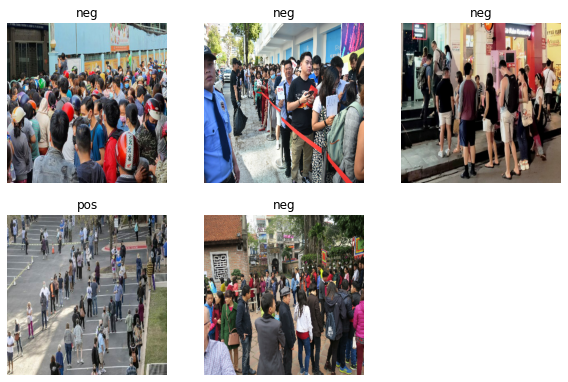

In [53]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(len(images)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Generate test dataset
As the original dataset doesn't contains a test set, I'll create one. To do so, determine how many batches of data are available in the training set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [54]:
val_batches = tf.data.experimental.cardinality(train_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 8
Number of test batches: 1


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [55]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [56]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaluate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

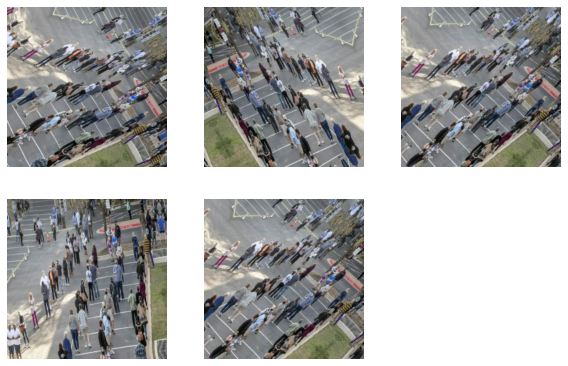

In [57]:
for images, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(len(images)):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [58]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **Inception V3** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of Inception V3 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a Inception V3 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [59]:
# Create the base model from the pre-trained model Inception V3
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `299x299x3` image into a `8x8x2048` block of features. Let's see what it does to an example batch of images:

In [60]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 8, 8, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. Inception V3 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [61]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [62]:
# (Optional) Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [63]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [64]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [65]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [66]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
# (Optional) Preview model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

The 2.5M parameters in Inception are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [68]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~87% accuracy on the validation set.


In [69]:
# initial_epochs = 10
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.7655 - accuracy: 0.6000
initial loss: 0.77
initial accuracy: 0.60
Epoch 1/50
8/8 [==============================] - 4s 67ms/step - loss: 0.7649 - accuracy: 0.5750 - val_loss: 0.6901 - val_accuracy: 0.8000
Epoch 2/50
8/8 [==============================] - 1s 50ms/step - loss: 0.6623 - accuracy: 0.5500 - val_loss: 0.7552 - val_accuracy: 0.4000
Epoch 3/50
8/8 [==============================] - 1s 50ms/step - loss: 0.7823 - accuracy: 0.4750 - val_loss: 0.6623 - val_accuracy: 0.8000
Epoch 4/50
8/8 [==============================] - 1s 49ms/step - loss: 0.6838 - accuracy: 0.5750 - val_loss: 0.7940 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 1s 50ms/step - loss: 0.8030 - accuracy: 0.5000 - val_loss: 0.7369 - val_accuracy: 0.4000
Epoch 6/50
8/8 [==============================] - 1s 50ms/step - loss: 0.7477 - accuracy: 0.4500 - val_loss: 0.7737 - val_accuracy: 0.6000
Epoch 7/50
8/8 [========================

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the Inception V3 base model as a fixed feature extractor.

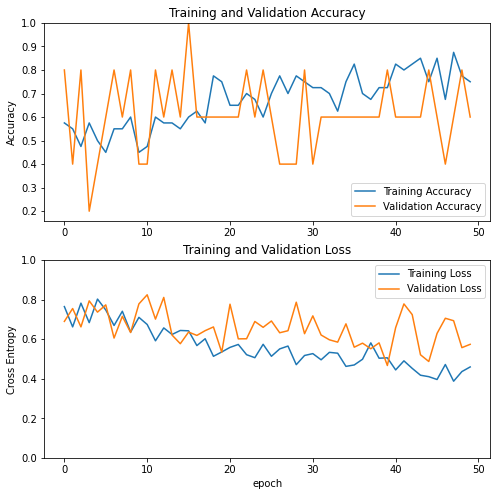

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an Inception V3 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole Inception model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [71]:
base_model.trainable = True

In [72]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# fine_tune_at = 280
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [73]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [74]:
# fine_tune_epochs = 5
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 50/60
8/8 [==============================] - 8s 237ms/step - loss: 0.4332 - accuracy: 0.8448 - val_loss: 0.5611 - val_accuracy: 0.8000
Epoch 51/60
8/8 [==============================] - 1s 76ms/step - loss: 0.2648 - accuracy: 0.9520 - val_loss: 0.4091 - val_accuracy: 0.8000
Epoch 52/60
8/8 [==============================] - 1s 76ms/step - loss: 0.2438 - accuracy: 0.9614 - val_loss: 0.6246 - val_accuracy: 0.4000
Epoch 53/60
8/8 [==============================] - 1s 76ms/step - loss: 0.1852 - accuracy: 0.9313 - val_loss: 0.5642 - val_accuracy: 0.6000
Epoch 54/60
8/8 [==============================] - 1s 75ms/step - loss: 0.0863 - accuracy: 0.9944 - val_loss: 0.7297 - val_accuracy: 0.4000
Epoch 55/60
8/8 [==============================] - 1s 76ms/step - loss: 0.0888 - accuracy: 0.9944 - val_loss: 0.5524 - val_accuracy: 0.6000
Epoch 56/60
8/8 [==============================] - 1s 77ms/step - loss: 0.0458 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.8000
Epoch 57/60
8/8 [==

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the Inception V3 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original Inception V3 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [75]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

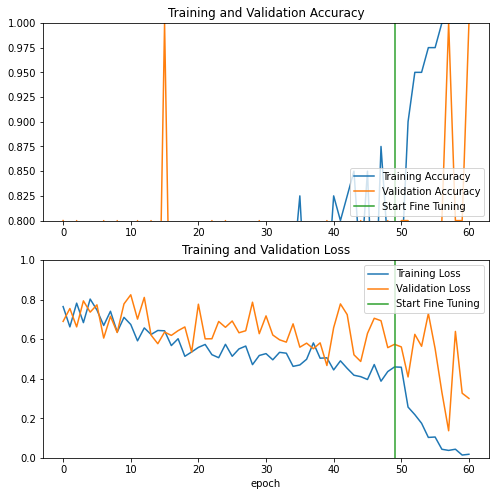

In [76]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [77]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 119ms/step - loss: 0.3561 - accuracy: 0.8000
Test accuracy : 0.800000011920929


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 1 1 0]
Labels:
 [0 1 1 1 0]


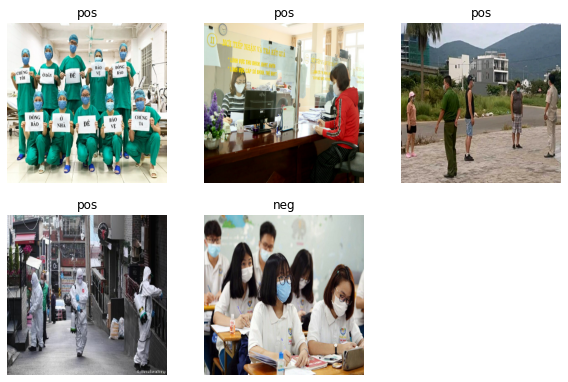

In [78]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(5):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## PREDICT A PICTURE

https://learnenglish.britishcouncil.org/sites/podcasts/files/styles/article/public/RS6243_175211709-hig.jpg?itok=_6Q8Yla4
This image most likely belongs to pos with a 94.85 percent confidence.


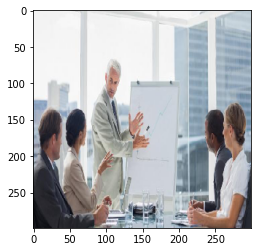

In [80]:
uri = input()
req = requests.get(uri)
req.raise_for_status()

with open(os.path.join('./predict.jpg'), 'wb') as f:
  f.write(req.content)

img = tf.keras.preprocessing.image.load_img("./predict.jpg", target_size=(299, 299))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])[0]
if score < 0.5:
  label_id = 0
  score = 1 - score
else:
  label_id = 1

plt.imshow(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[label_id], 100 * score)
)